In [1]:
import lightgbm as lgb
import sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from mlxtend.regressor import StackingCVRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
df = pd.read_csv("data.csv")
df_weather = pd.read_csv("IDCJAC0002_087031_Data12.csv")
display(df[:5])

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
## Check the unique number in each column
for i in df:
    print(i + " unique number is" , len(df[i].unique()))

Sex unique number is 3
Length unique number is 134
Diameter unique number is 111
Height unique number is 51
Whole weight unique number is 2429
Shucked weight unique number is 1515
Viscera weight unique number is 880
Shell weight unique number is 926
Rings unique number is 28


In [4]:
## I found the dataset has another description told the ring feature add 1.5 gives the age in years
df["Age"] = df['Rings'] + 1.5
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Age
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684,11.433684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000,2.500000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000,9.500000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000,10.500000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000,12.500000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000,30.500000


In [5]:
## From the above table, I found Height column have some 0 value. Remove it.
df = df[df['Height']>0]
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Age
count,4175.000000,4175.00000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000
mean,0.524065,0.40794,0.139583,0.829005,0.359476,0.180653,0.238834,9.935090,11.435090
std,0.120069,0.09922,0.041725,0.490349,0.221954,0.109605,0.139212,3.224227,3.224227
min,0.075000,0.05500,0.010000,0.002000,0.001000,0.000500,0.001500,1.000000,2.500000
25%,0.450000,0.35000,0.115000,0.442250,0.186250,0.093500,0.130000,8.000000,9.500000
50%,0.545000,0.42500,0.140000,0.800000,0.336000,0.171000,0.234000,9.000000,10.500000
75%,0.615000,0.48000,0.165000,1.153500,0.502000,0.253000,0.328750,11.000000,12.500000
max,0.815000,0.65000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000,30.500000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000002CC19588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000002EE75A90>]], dtype=object)

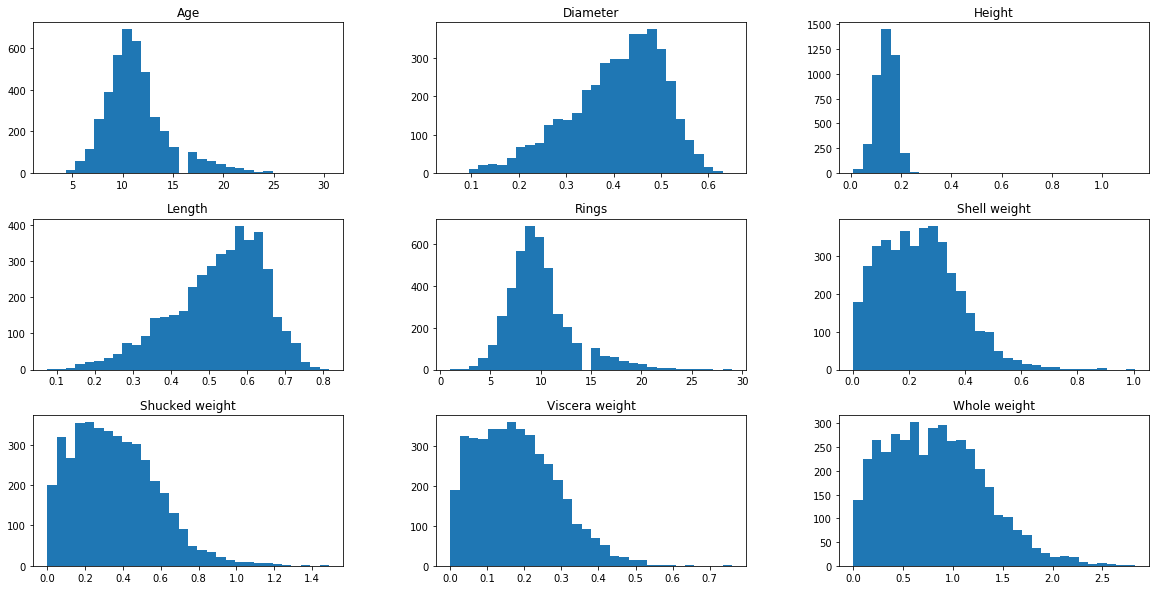

In [6]:
plt.figure(figsize=(20,20))
df.hist(figsize=(20,10), grid=False, bins = 30)

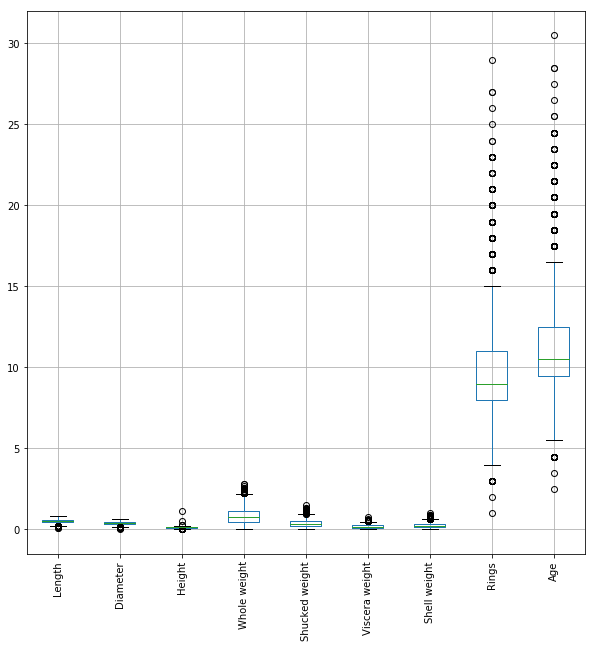

In [7]:
plt.figure(figsize=(10,10))
# for i in df.columns:
#     print(i)
#     plt.subplot(3, 3, count)
#     sns.boxplot(df[i])
#     count += 1
df.boxplot(rot = 90, figsize=(20,20))

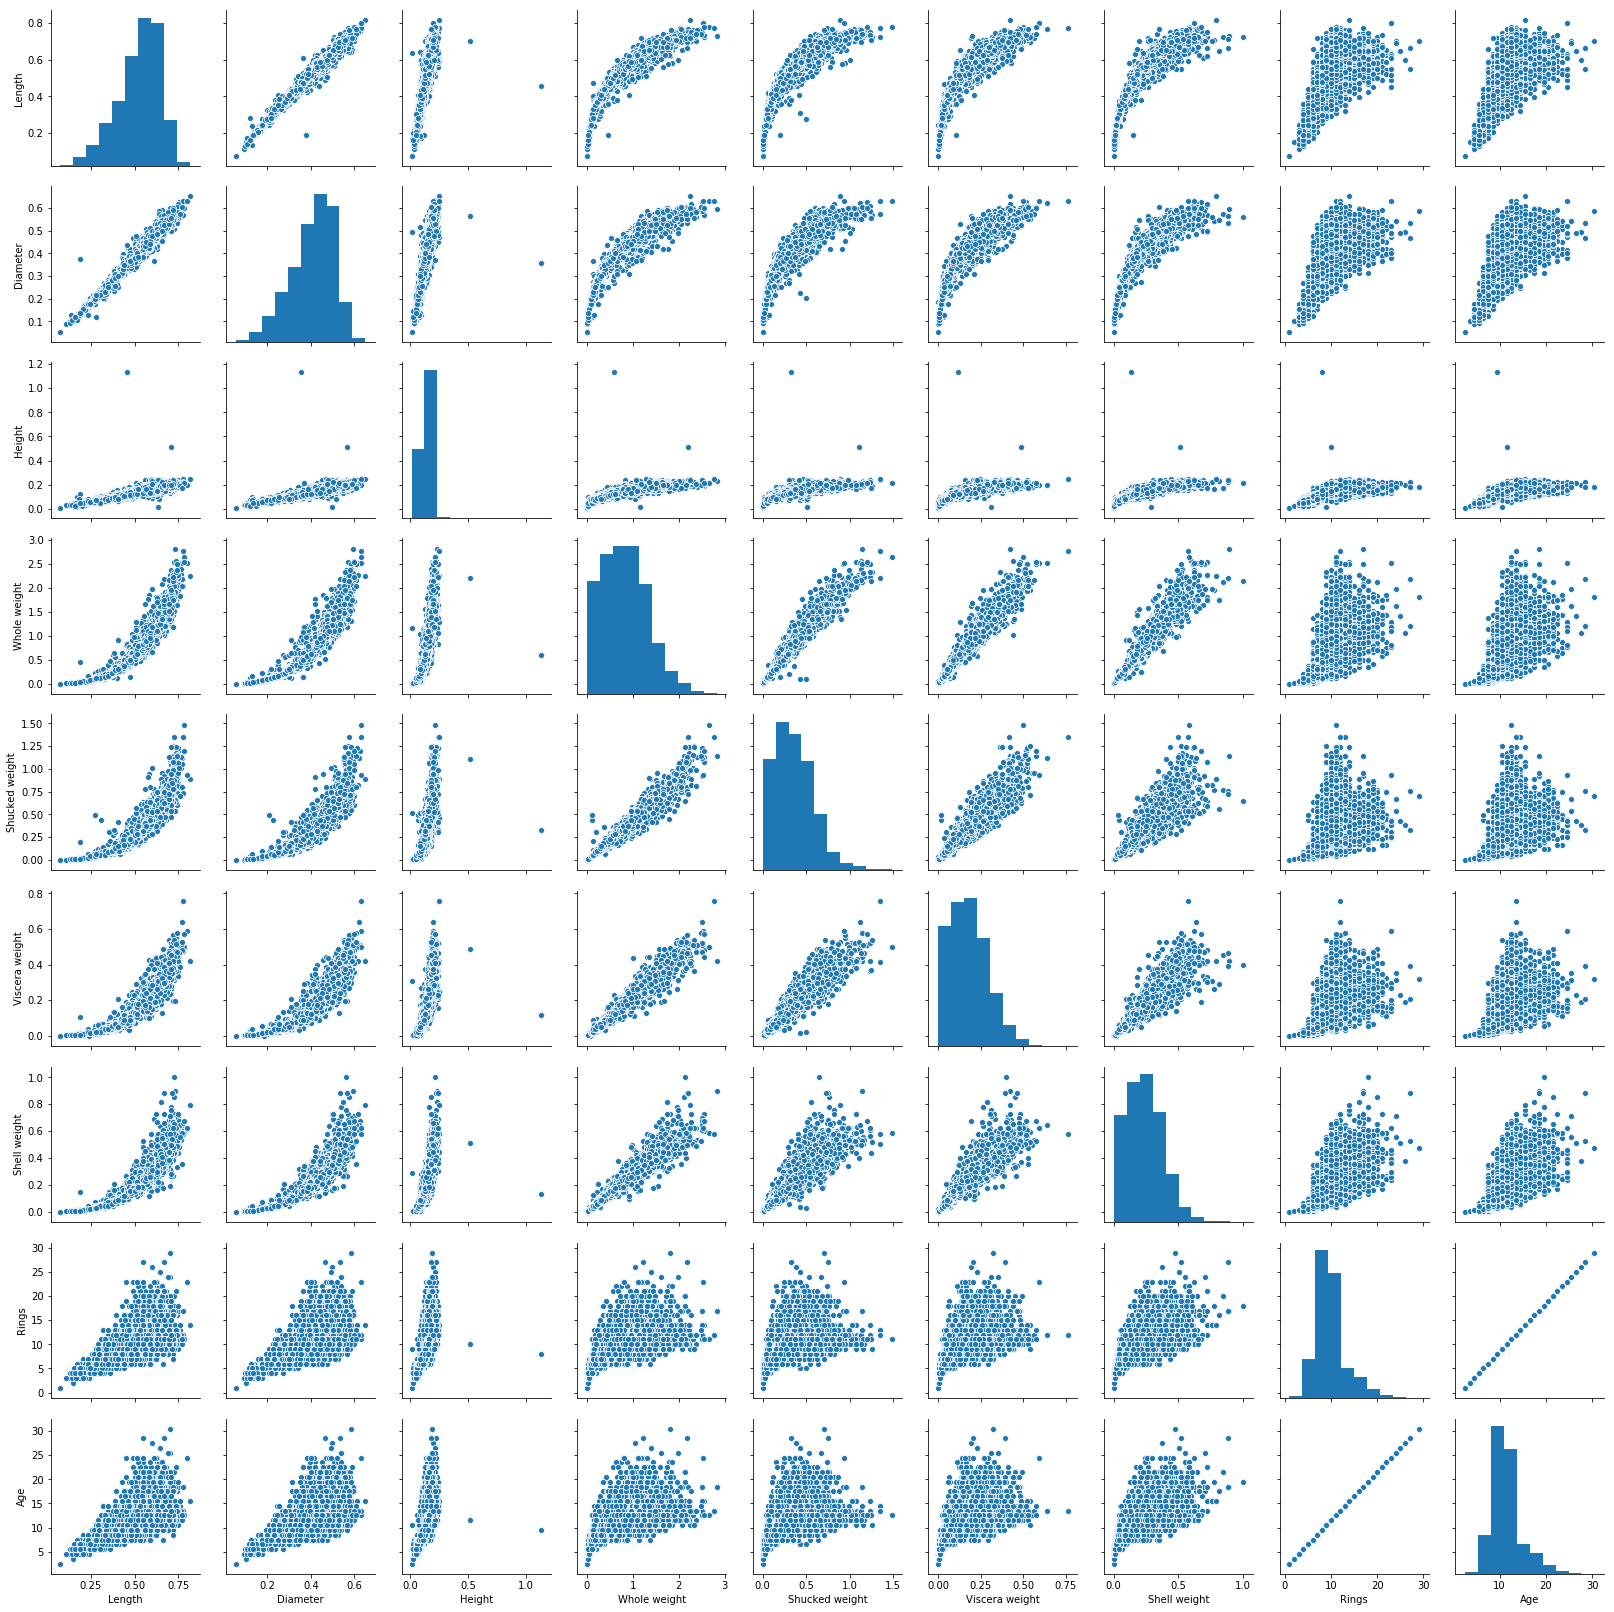

In [8]:
plt.figure(figsize=(10,10))
sns.pairplot(df[["Length", "Diameter", "Height", "Whole weight", "Shucked weight","Viscera weight", "Shell weight", "Rings","Age"]])

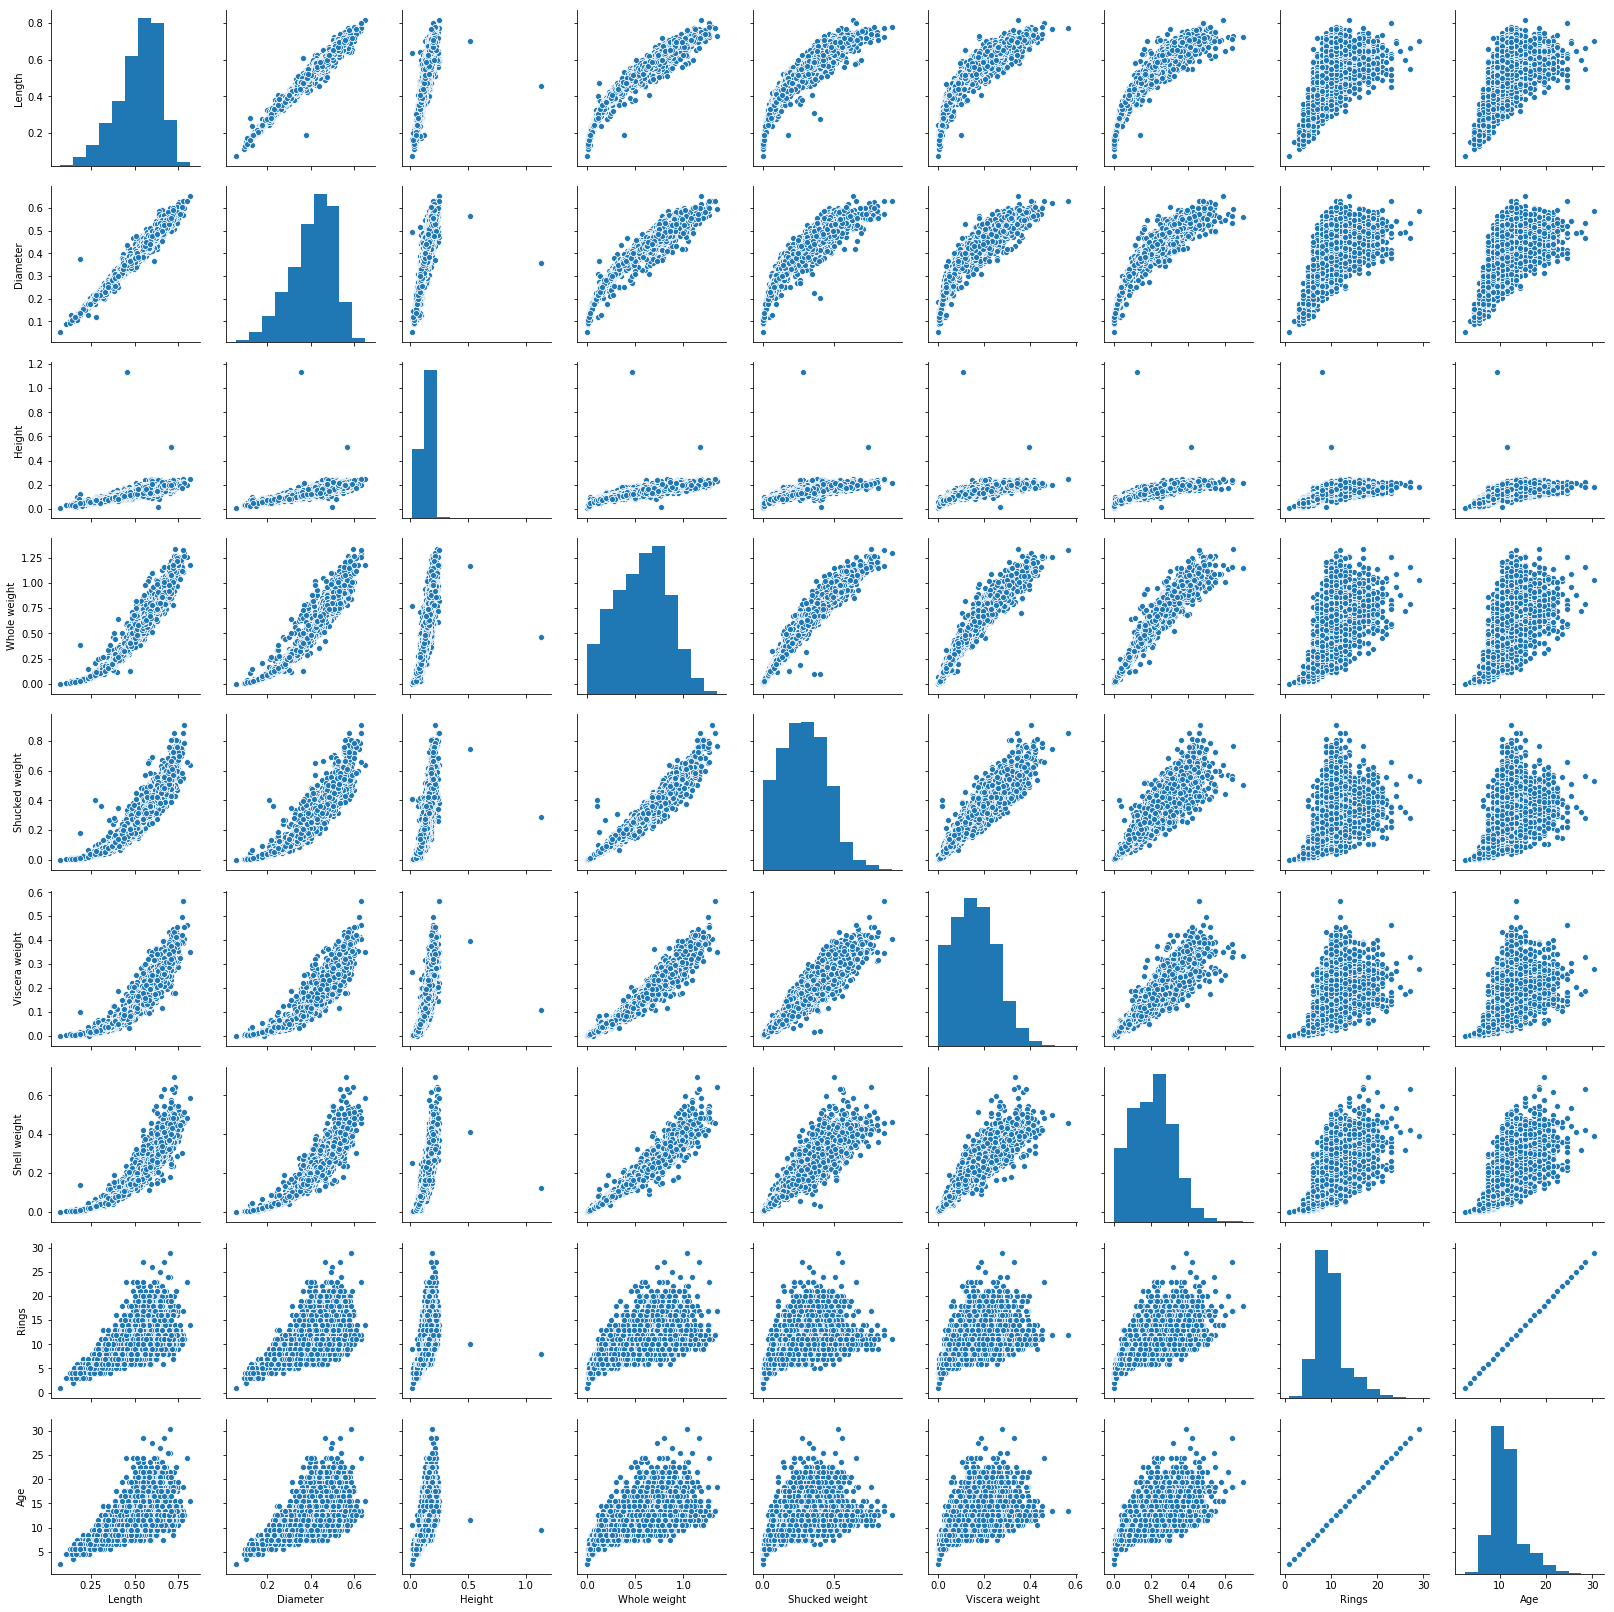

In [9]:
log_columns = ["Whole weight", "Shucked weight","Viscera weight", "Shell weight"]
df_log = df
for i in log_columns:
    df_log[i] = np.log1p(df[i])
    
plt.figure(figsize=(10,10))
sns.pairplot(df_log[["Length", "Diameter", "Height", "Whole weight", "Shucked weight","Viscera weight", "Shell weight", "Rings","Age"]])


# df = df_log

In [10]:
df.skew().sort_values()

Length           -0.640993
Diameter         -0.610182
Whole weight     -0.038664
Shucked weight    0.305985
Shell weight      0.315407
Viscera weight    0.375174
Rings             1.113754
Age               1.113754
Height            3.166364
dtype: float64

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Age
Length,1.000000,0.986802,0.828108,0.961584,0.927252,0.918800,0.920147,0.556464,0.556464
Diameter,0.986802,1.000000,0.834298,0.961647,0.922759,0.915742,0.927427,0.574418,0.574418
Height,0.828108,0.834298,1.000000,0.843860,0.797233,0.810533,0.833841,0.557625,0.557625
Whole weight,0.961584,0.961647,0.843860,1.000000,0.971774,0.966328,0.962584,0.567926,0.567926
Shucked weight,0.927252,0.922759,0.797233,0.971774,1.000000,0.940686,0.903297,0.446227,0.446227
Viscera weight,0.918800,0.915742,0.810533,0.966328,0.940686,1.000000,0.921294,0.516533,0.516533
Shell weight,0.920147,0.927427,0.833841,0.962584,0.903297,0.921294,1.000000,0.636089,0.636089
Rings,0.556464,0.574418,0.557625,0.567926,0.446227,0.516533,0.636089,1.000000,1.000000
Age,0.556464,0.574418,0.557625,0.567926,0.446227,0.516533,0.636089,1.000000,1.000000


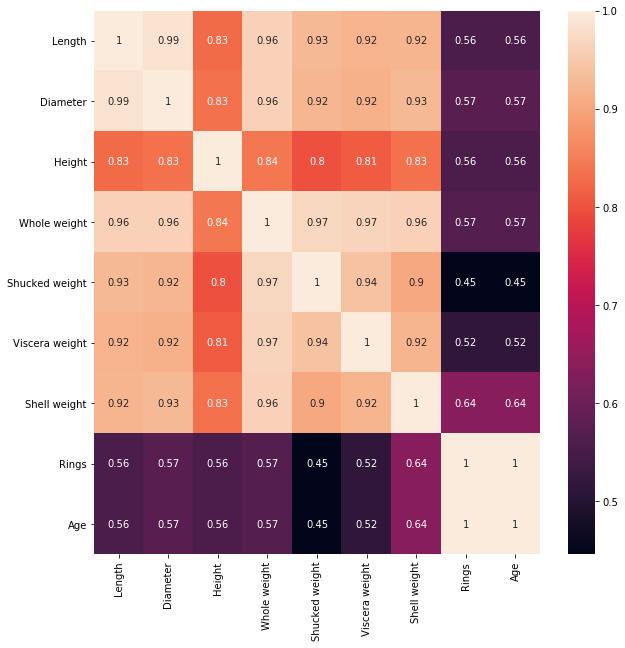

In [11]:
## Check the correlation of numerical data
display(df[["Length", "Diameter", "Height", "Whole weight", "Shucked weight","Viscera weight", "Shell weight", "Rings","Age"]].corr())

plt.figure(figsize=(10,10))
sns.heatmap(df[["Length", "Diameter", "Height", "Whole weight", "Shucked weight","Viscera weight", "Shell weight", "Rings","Age"]].corr(), annot = True)

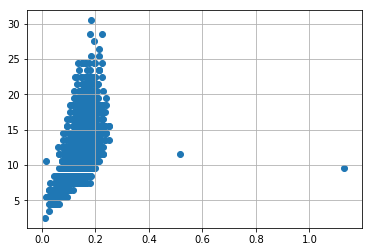

In [12]:
plt.scatter(x = df["Height"], y = df["Age"])
plt.grid(True)

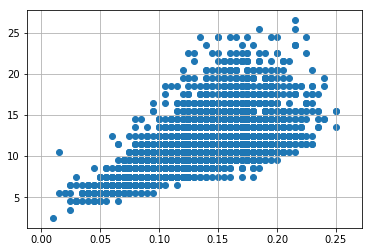

In [13]:
## Delete outlier in height-age
df = df[ (df[ "Height"]<0.4) & (df[ "Age"]<27) ]
plt.scatter(x = df["Height"], y = df["Age"])
plt.grid(True)


In [14]:
display(df[:10])

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Age
0,M,0.455,0.365,0.095,0.414755,0.202533,0.096219,0.139762,15,16.5
1,M,0.350,0.265,0.090,0.203349,0.094856,0.047361,0.067659,7,8.5
2,F,0.530,0.420,0.135,0.517006,0.228330,0.132343,0.190620,9,10.5
3,M,0.440,0.365,0.125,0.416075,0.195156,0.107957,0.144100,10,11.5
4,I,0.330,0.255,0.080,0.186480,0.085719,0.038740,0.053541,7,8.5
5,I,0.425,0.300,0.095,0.301215,0.131905,0.074644,0.113329,8,9.5
6,F,0.530,0.415,0.150,0.575208,0.212689,0.132343,0.285179,20,21.5
7,F,0.545,0.425,0.125,0.569849,0.257738,0.139327,0.231112,16,17.5
8,M,0.475,0.370,0.125,0.411778,0.195978,0.106610,0.152721,9,10.5
9,F,0.550,0.440,0.150,0.638955,0.273456,0.140631,0.277632,19,20.5


## Start Training

In [15]:
## I will use lightgbm to set the base line, and use rmse
X = df.drop(["Age", "Rings"], axis = 1)
y = df.Age

In [16]:
## one-hot encoding
X = pd.get_dummies(X)
display(X[:10])

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.414755,0.202533,0.096219,0.139762,0,0,1
1,0.350,0.265,0.090,0.203349,0.094856,0.047361,0.067659,0,0,1
2,0.530,0.420,0.135,0.517006,0.228330,0.132343,0.190620,1,0,0
3,0.440,0.365,0.125,0.416075,0.195156,0.107957,0.144100,0,0,1
4,0.330,0.255,0.080,0.186480,0.085719,0.038740,0.053541,0,1,0
5,0.425,0.300,0.095,0.301215,0.131905,0.074644,0.113329,0,1,0
6,0.530,0.415,0.150,0.575208,0.212689,0.132343,0.285179,1,0,0
7,0.545,0.425,0.125,0.569849,0.257738,0.139327,0.231112,1,0,0
8,0.475,0.370,0.125,0.411778,0.195978,0.106610,0.152721,0,0,1
9,0.550,0.440,0.150,0.638955,0.273456,0.140631,0.277632,1,0,0


In [17]:
## Normalize data
from sklearn.preprocessing import StandardScaler
Normal = StandardScaler()

X = Normal.fit_transform(X)
X = pd.DataFrame(X)

In [18]:
random_seed = 10 # set seed for same train test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_seed, test_size = 0.2)

In [19]:
X = X.astype('float')
display(X)

,0,1,2,3,4,5,6,7,8,9
0,-0.574255,-0.431635,-1.152669,-0.570304,-0.577076,-0.719309,-0.618823,-0.674647,-0.688234,1.316727
1,-1.448916,-1.439948,-1.283058,-1.359143,-1.255899,-1.255648,-1.274828,-0.674647,-0.688234,1.316727
2,0.050502,0.122937,-0.109559,-0.188765,-0.414442,-0.322756,-0.156107,1.482257,-0.688234,-0.759459
3,-0.699207,-0.431635,-0.370337,-0.565378,-0.623583,-0.590452,-0.579352,-0.674647,-0.688234,1.316727
4,-1.615518,-1.540779,-1.543835,-1.422089,-1.313499,-1.350282,-1.403274,-0.674647,1.452995,-0.759459
5,-0.824159,-1.087038,-1.152669,-0.993966,-1.022330,-0.956151,-0.859316,-0.674647,1.452995,-0.759459
6,0.050502,0.072522,0.281607,0.028407,-0.513047,-0.322756,0.704199,1.482257,-0.688234,-0.759459
7,0.175454,0.173353,-0.370337,0.008411,-0.229046,-0.246091,0.212289,1.482257,-0.688234,-0.759459
8,-0.407653,-0.381219,-0.370337,-0.581411,-0.618399,-0.605244,-0.500919,-0.674647,-0.688234,1.316727
9,0.217104,0.324600,0.281607,0.266272,-0.129955,-0.231775,0.635534,1.482257,-0.688234,-0.759459


In [20]:
## Evaluation methods
## I use Root Mean Squared Logarithmic Error (RMSLE) to evaluate the predict result
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [21]:
from lightgbm import LGBMRegressor
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=8,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [22]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.utils.validation import column_or_1d

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

y = column_or_1d(y, warn=False)
print('lightgbm')
lightgbm.fit(X_train, y_train)

lightgbm: 2.1528 (0.0960)
 2019-04-08 16:20:42.683138
lightgbm


LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.2, feature_fraction_seed=7,
       importance_type='split', learning_rate=0.01, max_bin=200,
       max_depth=-1, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=5000, n_jobs=-1, num_leaves=8,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0, verbose=-1)

In [23]:
y_pred = lightgbm.predict(X_test)
print('Lightgbm result')
print(rmsle(y_test, y_pred))

Lightgbm result
2.10846017907


## Stacking

In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))  

svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

gbr = GradientBoostingRegressor(n_estimators=3000, 
                                learning_rate=0.05, 
                                max_depth=4, 
                                max_features='sqrt', 
                                min_samples_leaf=15, 
                                min_samples_split=10, 
                                loss='huber', 
                                random_state =42)        

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=8,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [25]:
from sklearn.utils.validation import column_or_1d
y = np.array(y).ravel()
y = column_or_1d(y, warn=False)
display(y.shape)

(4169,)

In [26]:
stack_gen = StackingCVRegressor(regressors=(lasso, gbr, xgboost, lightgbm),
                                meta_regressor=lightgbm,
                                use_features_in_secondary=True)

In [27]:
lasso_y = y.reshape(-1,1)

display(lasso_y)
score = cv_rmse(lasso , lasso_y)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

array([[ 16.5],
       [  8.5],
       [ 10.5],
       ..., 
       [ 10.5],
       [ 11.5],
       [ 13.5]])

LASSO: 0.0000 (0.0000)
 2019-04-08 16:20:44.843261
SVR: 2.3855 (0.1614)
 2019-04-08 16:20:51.362634
lightgbm: 2.1528 (0.0960)
 2019-04-08 16:21:02.898294
gbr: 2.1620 (0.1006)
 2019-04-08 16:22:22.801864
xgboost: 2.1001 (0.1052)
 2019-04-08 16:22:54.663687


In [28]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

y = column_or_1d(y, warn=False)
train_lgb = lgb.Dataset(X, y)
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
stack_gen
Lasso
Svr
GradientBoosting
xgboost
lightgbm


In [29]:
def blend_models_predict(X):
    return ((0.15 * lasso_model_full_data.predict(X)) + \
            (0.05 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.2 * xgb_model_full_data.predict(X)) + \
            (0.2 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

print('RMSLE after using stacking')
print(rmsle(y, blend_models_predict(X)))

RMSLE after using stacking
1.72846075472


In [30]:
import math

start_year = 1994 - math.ceil(max(df['Age']))
end_year = 1994
print(start_year, end_year)
df_weather = df_weather[ (df_weather['Year']>=start_year) & (df_weather['Year']<=end_year) ]
display(df_weather[:5])
display(df_weather.info())

1967 1994


,Product code,Station Number,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
24,IDCJAC0002,87031,1967,23.8,27.3,23.8,21.7,18.0,14.4,14.0,14.4,16.7,20.8,22.7,22.4,20.0
25,IDCJAC0002,87031,1968,27.7,28.4,25.4,22.8,15.3,13.2,12.9,14.6,16.7,19.7,21.8,22.9,20.1
26,IDCJAC0002,87031,1969,28.1,25.9,23.1,21.3,15.9,13.6,15.2,15.4,14.4,18.8,21.1,22.9,19.6
27,IDCJAC0002,87031,1970,24.2,25.3,22.8,21.1,15.4,14.1,14.0,14.3,15.3,19.1,21.4,24.2,19.3
28,IDCJAC0002,87031,1971,25.7,27.3,25.8,22.1,16.5,14.2,13.9,14.8,16.7,18.7,20.1,24.5,20.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 24 to 51
Data columns (total 16 columns):
Product code      28 non-null object
Station Number    28 non-null int64
Year              28 non-null int64
Jan               28 non-null object
Feb               28 non-null object
Mar               28 non-null object
Apr               28 non-null object
May               28 non-null object
Jun               28 non-null object
Jul               28 non-null object
Aug               28 non-null object
Sep               28 non-null object
Oct               28 non-null object
Nov               28 non-null object
Dec               28 non-null object
Annual            28 non-null object
dtypes: int64(2), object(14)
memory usage: 3.7+ KB


None

In [31]:
df_weather["Annual"] = df_weather.Annual.astype(float)
df_add_new_feature = pd.DataFrame(df)
df_add_new_feature['Born_year'] = 0
for i in range(len(df_add_new_feature)):
    df_add_new_feature.iloc[i,-1] = int(float(1994) - math.ceil(df_add_new_feature.iloc[i,-2]))

display(df_add_new_feature[:5])

from statistics import mean

df_add_new_feature['Max_temp_in_life'] = 0
df_add_new_feature['Min_temp_in_life'] = 0
df_add_new_feature['Avg_temp_in_life'] = 0
for i in range(len(df_add_new_feature)):
    start_year = df_add_new_feature.iloc[i,10]
    temp = df_weather[ (df_weather['Year']>=start_year) ]
    df_add_new_feature.iloc[i,-3] = max(temp['Annual'])
    df_add_new_feature.iloc[i,-2] = min(temp['Annual'])
    df_add_new_feature.iloc[i,-1] = temp['Annual'].mean()
display(df_add_new_feature)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Age,Born_year
0,M,0.455,0.365,0.095,0.414755,0.202533,0.096219,0.139762,15,16.5,1977
1,M,0.350,0.265,0.090,0.203349,0.094856,0.047361,0.067659,7,8.5,1985
2,F,0.530,0.420,0.135,0.517006,0.228330,0.132343,0.190620,9,10.5,1983
3,M,0.440,0.365,0.125,0.416075,0.195156,0.107957,0.144100,10,11.5,1982
4,I,0.330,0.255,0.080,0.186480,0.085719,0.038740,0.053541,7,8.5,1985


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Age,Born_year,Max_temp_in_life,Min_temp_in_life,Avg_temp_in_life
0,M,0.455,0.365,0.095,0.414755,0.202533,0.096219,0.139762,15,16.5,1977,20.7,18.6,19.716667
1,M,0.350,0.265,0.090,0.203349,0.094856,0.047361,0.067659,7,8.5,1985,20.3,18.6,19.510000
2,F,0.530,0.420,0.135,0.517006,0.228330,0.132343,0.190620,9,10.5,1983,20.3,18.6,19.483333
3,M,0.440,0.365,0.125,0.416075,0.195156,0.107957,0.144100,10,11.5,1982,20.7,18.6,19.576923
4,I,0.330,0.255,0.080,0.186480,0.085719,0.038740,0.053541,7,8.5,1985,20.3,18.6,19.510000
5,I,0.425,0.300,0.095,0.301215,0.131905,0.074644,0.113329,8,9.5,1984,20.3,18.6,19.500000
6,F,0.530,0.415,0.150,0.575208,0.212689,0.132343,0.285179,20,21.5,1972,20.7,18.6,19.773913
7,F,0.545,0.425,0.125,0.569849,0.257738,0.139327,0.231112,16,17.5,1976,20.7,18.6,19.721053
8,M,0.475,0.370,0.125,0.411778,0.195978,0.106610,0.152721,9,10.5,1983,20.3,18.6,19.483333
9,F,0.550,0.440,0.150,0.638955,0.273456,0.140631,0.277632,19,20.5,1973,20.7,18.6,19.740909


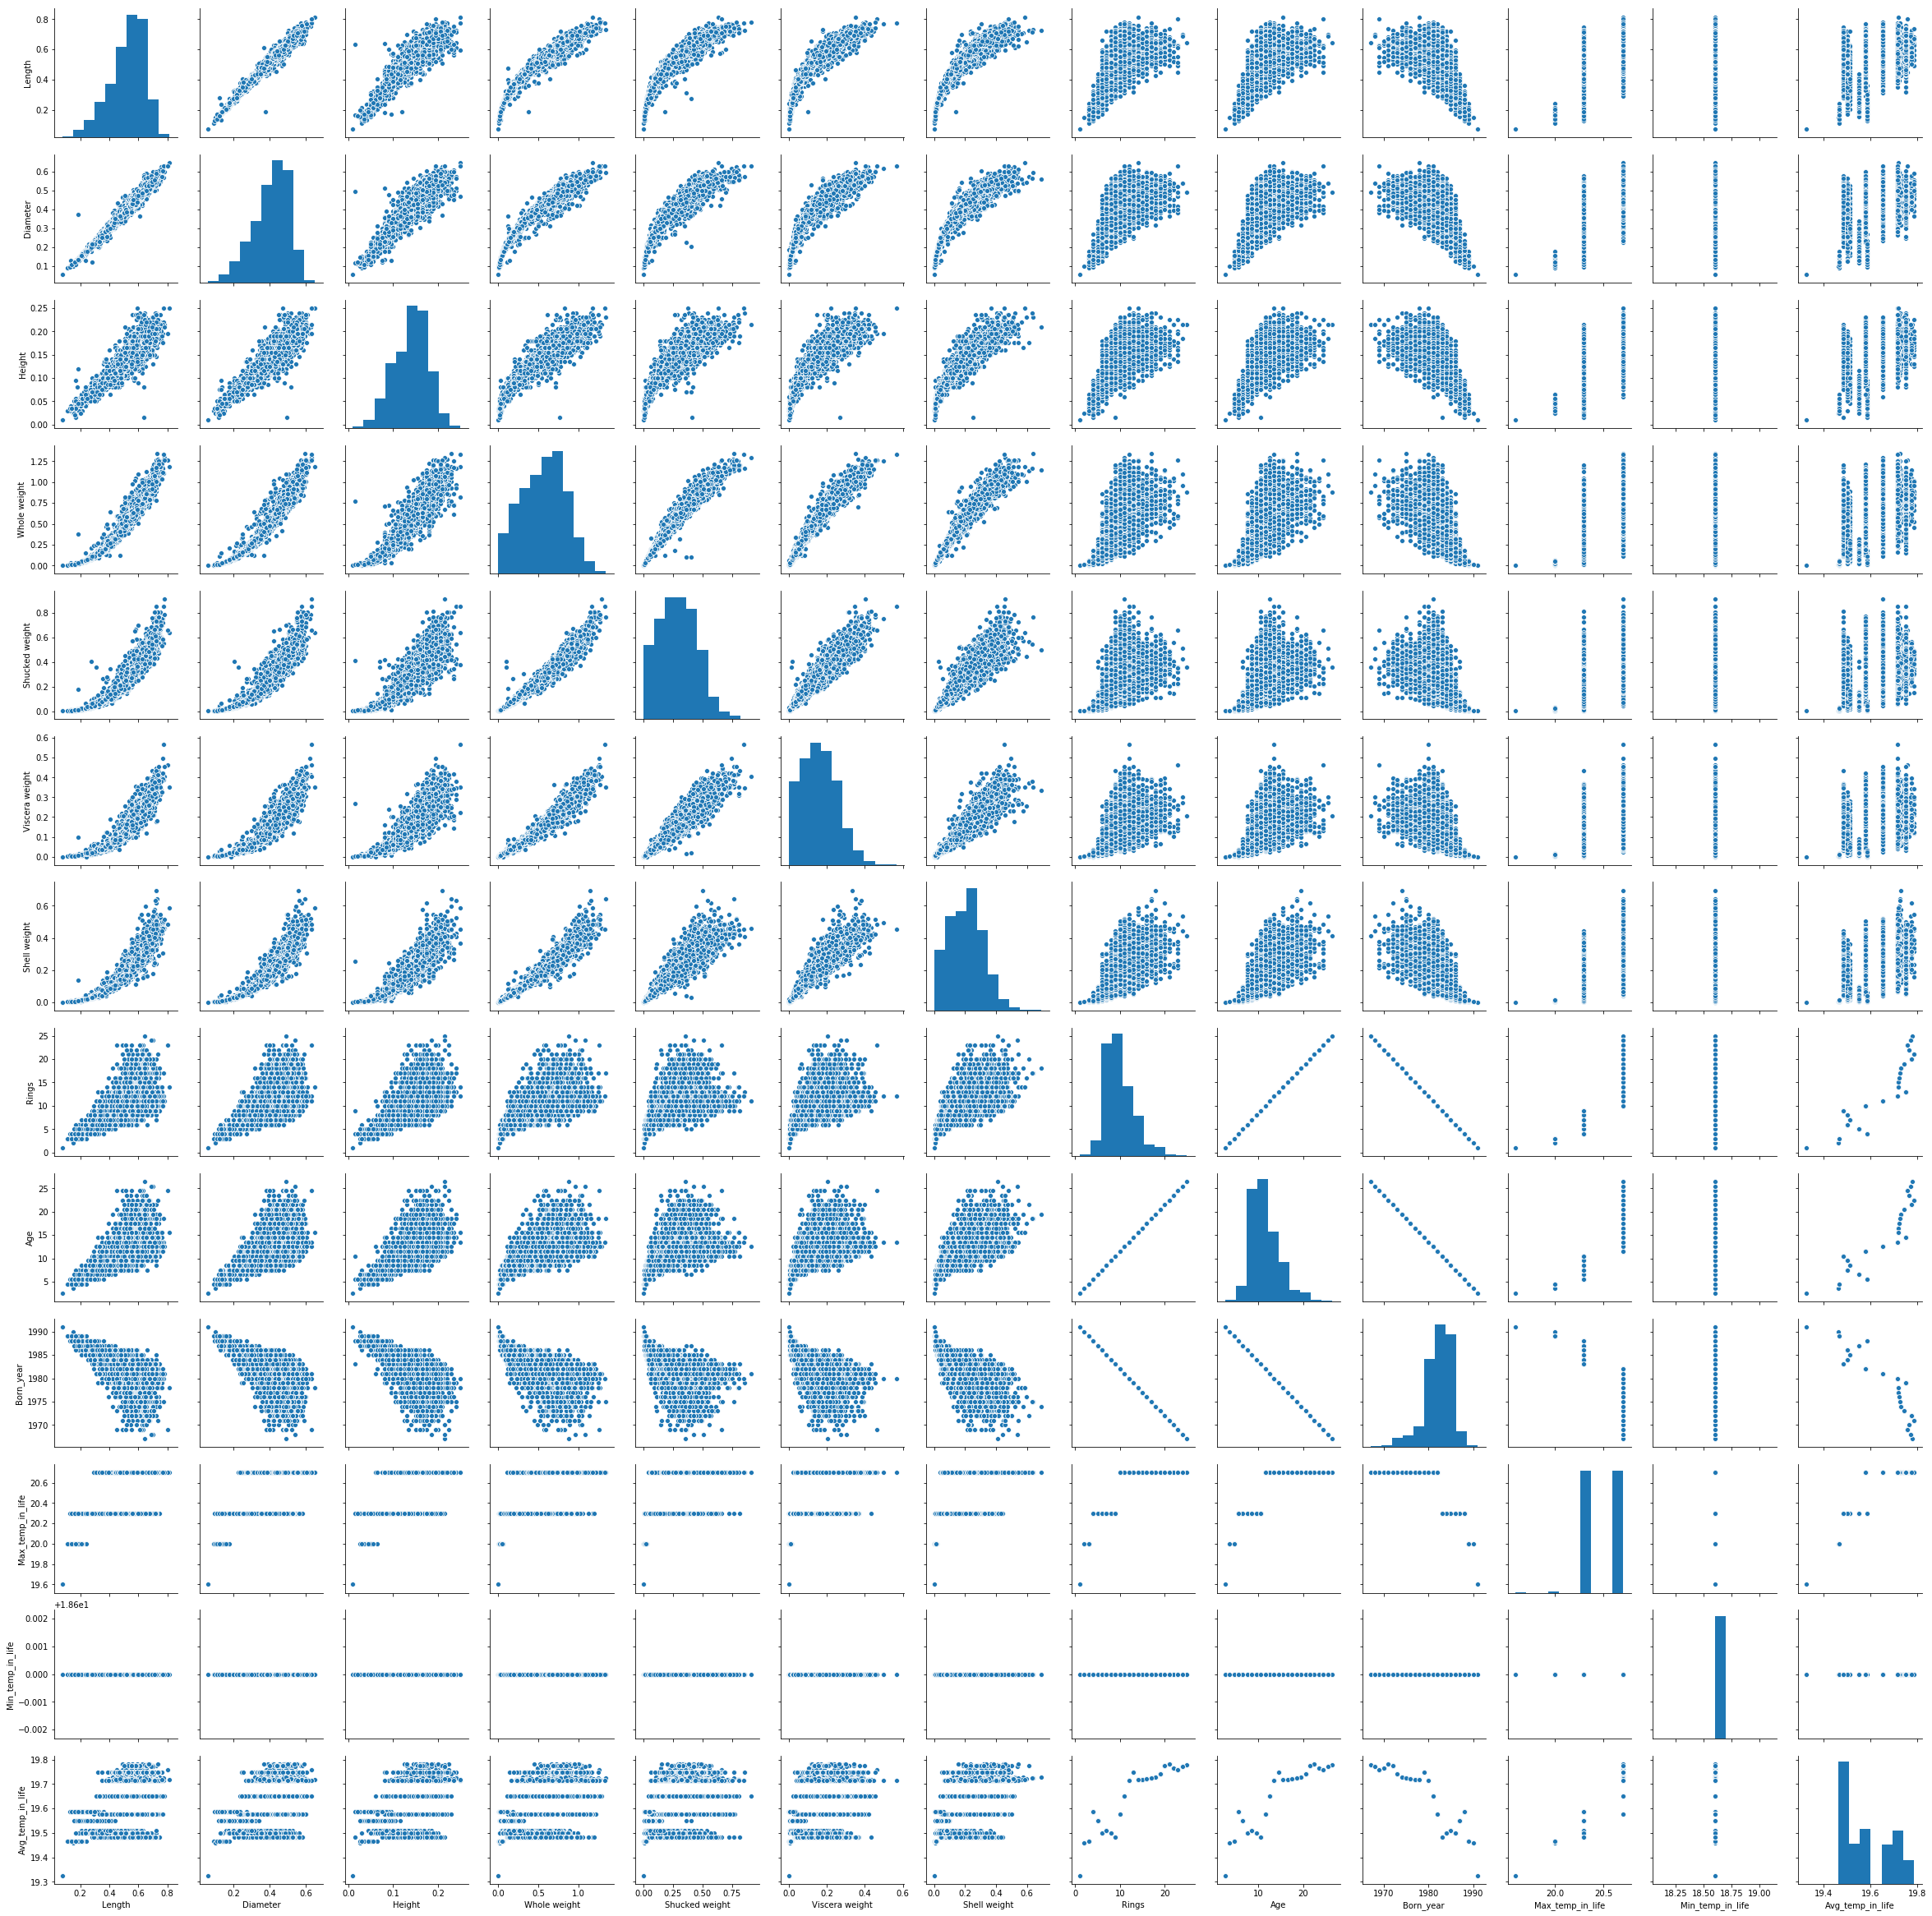

In [32]:
plt.figure(figsize=(10,10))
sns.pairplot(df_add_new_feature[["Length", "Diameter", "Height", "Whole weight", "Shucked weight","Viscera weight", "Shell weight", "Rings","Age","Born_year", "Max_temp_in_life", "Min_temp_in_life", "Avg_temp_in_life"]])

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Age,Born_year,Max_temp_in_life,Min_temp_in_life,Avg_temp_in_life
Length,1.000000e+00,9.868145e-01,9.010166e-01,9.617391e-01,9.273920e-01,9.188430e-01,9.211013e-01,5.600678e-01,5.600678e-01,-5.600678e-01,5.276547e-01,4.183794e-15,3.876923e-01
Diameter,9.868145e-01,1.000000e+00,9.072323e-01,9.617176e-01,9.229113e-01,9.157958e-01,9.281702e-01,5.770886e-01,5.770886e-01,-5.770886e-01,5.421138e-01,1.432163e-14,4.071702e-01
Height,9.010166e-01,9.072323e-01,1.000000e+00,9.153171e-01,8.616017e-01,8.797731e-01,9.076153e-01,6.117495e-01,6.117495e-01,-6.117495e-01,5.632228e-01,-2.458380e-14,4.595370e-01
Whole weight,9.617391e-01,9.617176e-01,9.153171e-01,1.000000e+00,9.718977e-01,9.663429e-01,9.629388e-01,5.697965e-01,5.697965e-01,-5.697965e-01,5.467415e-01,-3.312282e-15,4.358914e-01
Shucked weight,9.273920e-01,9.229113e-01,8.616017e-01,9.718977e-01,1.000000e+00,9.405717e-01,9.041579e-01,4.487998e-01,4.487998e-01,-4.487998e-01,4.644119e-01,-5.905149e-15,3.358693e-01
Viscera weight,9.188430e-01,9.157958e-01,8.797731e-01,9.663429e-01,9.405717e-01,1.000000e+00,9.219291e-01,5.198104e-01,5.198104e-01,-5.198104e-01,5.257541e-01,1.526765e-15,4.166182e-01
Shell weight,9.211013e-01,9.281702e-01,9.076153e-01,9.629388e-01,9.041579e-01,9.219291e-01,1.000000e+00,6.359912e-01,6.359912e-01,-6.359912e-01,5.868854e-01,-1.758520e-15,5.118230e-01
Rings,5.600678e-01,5.770886e-01,6.117495e-01,5.697965e-01,4.487998e-01,5.198104e-01,6.359912e-01,1.000000e+00,1.000000e+00,-1.000000e+00,7.441633e-01,1.482218e-15,8.219971e-01
Age,5.600678e-01,5.770886e-01,6.117495e-01,5.697965e-01,4.487998e-01,5.198104e-01,6.359912e-01,1.000000e+00,1.000000e+00,-1.000000e+00,7.441633e-01,1.482218e-15,8.219971e-01
Born_year,-5.600678e-01,-5.770886e-01,-6.117495e-01,-5.697965e-01,-4.487998e-01,-5.198104e-01,-6.359912e-01,-1.000000e+00,-1.000000e+00,1.000000e+00,-7.441633e-01,3.264940e-14,-8.219971e-01


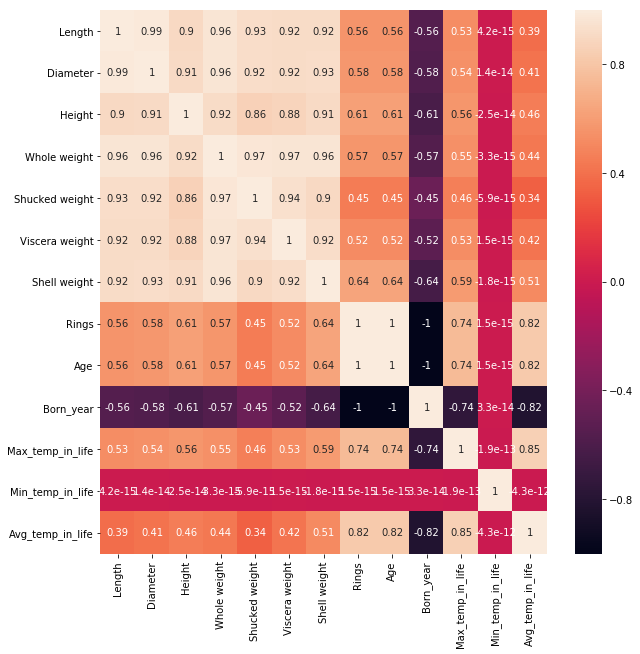

In [33]:
## Check the correlation of numerical data
display(df_add_new_feature[["Length", "Diameter", "Height", "Whole weight", "Shucked weight","Viscera weight", "Shell weight", "Rings","Age","Born_year", "Max_temp_in_life", "Min_temp_in_life", "Avg_temp_in_life"]].corr())

plt.figure(figsize=(10,10))
sns.heatmap(df_add_new_feature[["Length", "Diameter", "Height", "Whole weight", "Shucked weight","Viscera weight", "Shell weight", "Rings","Age","Born_year", "Max_temp_in_life", "Min_temp_in_life", "Avg_temp_in_life"]].corr(), annot = True)